# Emotion Classification from Audio Files

**Overview**

This project adapt a computer vision model, ResNet18, for the classification of emotions from audio recordings using a unique dataset originally designed for audtiory testing.

**Dataset**

The data comes from University of Toronto ([Toronto Emotional Speech Set](https://borealisdata.ca/dataset.xhtml?persistentId=doi%3A10.5683%2FSP2%2FE8H2MF)) and contains 2,800 audio recordings of two actors saying a target word in the phrase "Say the word ___".

There are 7 different emotions:
1. Anger
2. Disgust
3. Fear
4. Happiness
5. Pleasant Surprise
6. Sadness
7. Neutral

**Modeling Approach**

In this notebook, I process these audio recordings, converting them into spectograms - a visual representation of the specturm of frequencies in a sound over time. Using these spectograms as images, I leveraged some of the state-of-the-art convolutional neural network to classify each audio into one of the seven emotional categories.

# Loading and Preprocessing the data

In [ ]:
from pathlib import Path
cwd = Path('')
raw_audio_dir = "tess_raw_audio"

In [ ]:
sample_audio = cwd / raw_audio_dir / "YAF_youth_sad.wav"
sample_audio.is_file()

True

### Let's listen to a sample audio of a female actor saying the word "youth" in a sad tone.

In [ ]:
import IPython
IPython.display.Audio(sample_audio)

### Now, let's sample the male & female actors saying the word "youth" in different emotions.

In [ ]:
data_dir = cwd / raw_audio_dir
youth_word_audios = list(data_dir.glob("*_youth_*.wav"))

In [ ]:
len(youth_word_audios)

14

### Convert audio into spectogram with Librosa library

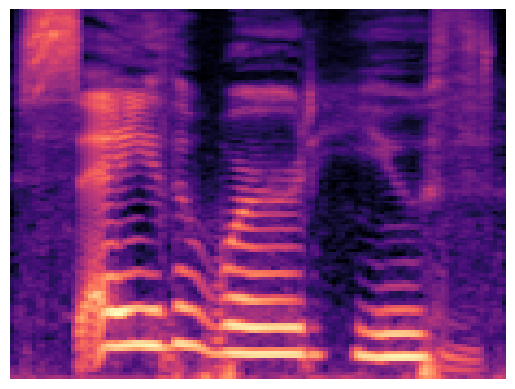

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import os

fig, axes = plt.subplots()
# Load the audio file
y, sr = librosa.load(youth_word_audios[0], sr=None)

# Create a spectogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.power_to_db(S, ref=np.max)

# Display the spectogram
img = librosa.display.specshow(S_DB, sr=sr, x_axis="time", y_axis="mel", ax=axes)
plt.axis('off')
plt.show()

### Let's see a bunch of them

* It's interesting to note that there seems to be patterns that distinguish different categories that I can at least recognize, suggesting that a vision model might probably be able to distinguish them.

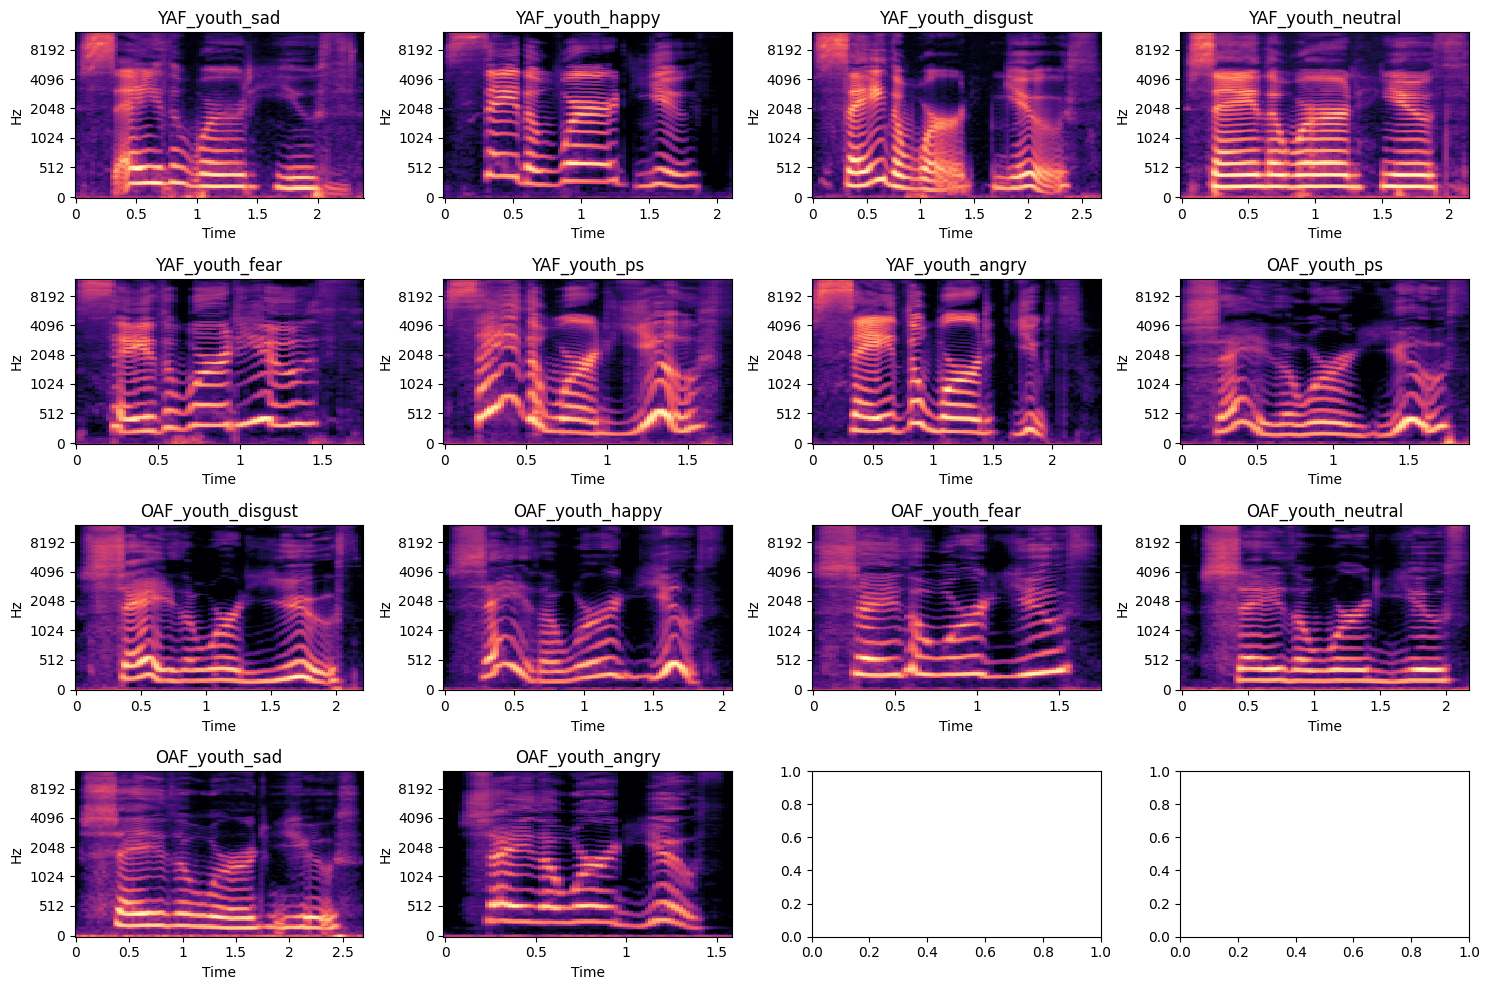

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))
axes = axes.flatten()

for i, audio_path in enumerate(youth_word_audios):
  # Load the audio file
  y, sr = librosa.load(audio_path, sr=None)

  # Create a spectogram
  S = librosa.feature.melspectrogram(y=y, sr=sr)
  S_DB = librosa.power_to_db(S, ref=np.max)

  # Display the spectogram
  img = librosa.display.specshow(S_DB, sr=sr, x_axis="time", y_axis="mel",
                                 ax=axes[i])
  # Extract label & show as title
  label = str(audio_path).split("/")[-1][:-4]
  axes[i].set(title=label)

fig.tight_layout()
plt.show()

In [ ]:
filenames = list(data_dir.glob("*.wav"))

In [ ]:
str(filenames[0]).split("/")[-1]

'YAF_hash_ps.wav'

### Let's write a helper function to extract the emotions (labels)

In [ ]:
def extract_emotion(file_name: str) -> str:
    """
    Given the name of the file, return the label
    indicating the emotion associated with the audio.
    """
    # Split the filename at each underscore
    parts = file_name.split('_')
    # Label is after second
    label_with_extension = parts[-1]
    # Remove the extension to get only the label
    label = label_with_extension[:-4]
    return label

In [ ]:
emotion_labels = list(map(extract_emotion, [str(f).split("/")[-1] for f in filenames]))

### We have a balanced dataset.

In [ ]:
from collections import Counter
count = Counter(emotion_labels)
print(count)

Counter({'ps': 400, 'sad': 400, 'neutral': 400, 'angry': 400, 'disgust': 400, 'fear': 400, 'happy': 400})


### Let's create two helper functions:

1. Create a spectogram from audio and save it in the destination.
2. Create train/test directory structure and populate them with spectograms.

In [ ]:
def create_spectogram(file_path, save_path):
  """
  Takes a path of the raw audio file and turns into
  spectogram and save it in the path provided.
  """
  # Load the audio file
  sample, sample_rate = librosa.load(file_path, sr=None)
  # Create Mel Spectogram
  S = librosa.feature.melspectrogram(y=sample, sr=sample_rate)
  S_DB = librosa.power_to_db(S, ref=np.max)
  fig, ax = plt.subplots()
  img = librosa.display.specshow(S_DB, sr=sample_rate, x_axis='time',
                                 y_axis='mel', ax=ax)
  # Turn off the axis for saving
  plt.axis('off')
  plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
  plt.close(fig)

In [ ]:
def create_spectograms(filenames, cwd):
  """
  Create a new directory wiht raw audio converted to spectograms.
  Stratify split into train and validation sets
  """
  # Create directories
  spectogram_path = cwd / "emotions_spectograms"
  train_path = spectogram_path / "train"
  val_path = spectogram_path / "test"
  os.makedirs(train_path, exist_ok=True)
  os.makedirs(val_path, exist_ok=True)

  # Extracting labels
  labels = list(map(extract_emotion, [str(f).split("/")[-1] for f in filenames]))
  splitter = RandomSplitter(valid_pct=0.15, seed=42)
  # Stratified Sampling based on emotion
  splits = splitter(labels)
  train_idx, val_idx = splits[0], splits[1]

  for i, file in enumerate(filenames):
    save_dir = train_path if i in train_idx else val_path
    save_filename = str(file).split("/")[-1][:-4] + ".png"
    save_path =  save_dir / save_filename
    create_spectogram(file, save_path)

### Store the data for modeling

In [ ]:
filenames = list(data_dir.glob("*.wav"))

In [ ]:
create_spectograms(filenames, cwd)

### Checking the splits

Double-check the results of splitting and check whether the presence of emotions labels are balanced.

In [ ]:
spectogram_path = cwd / "emotions_spectograms"
train_dir, test_dir = spectogram_path / "train", spectogram_path / "test"
train_files = list(train_dir.glob("*.png"))
test_files = list(test_dir.glob("*.png"))
train_labels = list(map(extract_emotion, [str(f).split("/")[-1] for f in train_files]))
test_labels = list(map(extract_emotion, [str(f).split("/")[-1] for f in test_files]))

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)
train_total = len(train_labels)
test_total = len(test_labels)
print("Training Data Size: ", train_total)
print("Test Data Size: ", test_total)
for label in set(train_labels):
  train_ratio = train_counts[label] / train_total
  test_ratio = test_counts[label] / test_total
  print(f"Label: {label} Train Ratio: {train_ratio:.3f} Test Ratio: {test_ratio:.3f}")

Training Data Size:  2380
Test Data Size:  420
Label: ps Train Ratio: 0.146 Test Ratio: 0.124
Label: disgust Train Ratio: 0.143 Test Ratio: 0.143
Label: sad Train Ratio: 0.143 Test Ratio: 0.140
Label: happy Train Ratio: 0.143 Test Ratio: 0.143
Label: neutral Train Ratio: 0.144 Test Ratio: 0.136
Label: fear Train Ratio: 0.140 Test Ratio: 0.160
Label: angry Train Ratio: 0.141 Test Ratio: 0.155


### Train and Evaluate the model

In [ ]:
!pip install -Uqq fastai

In [ ]:
from fastai import *
from fastai.vision.all import *
from fastai.data.transforms import RandomSplitter

### DataBlock and DataLoaders

Define the DataBlock for Data Loaders, allowing the images to be loaded appropriately from the directories.

In [ ]:
def get_y(filepath): return extract_emotion(str(filepath).split("/")[-1])
def is_test_dir(s): return Path(s).parent.name == "test"

In [ ]:
# Note: It doesn't make sense to apply common image transformation methods to
#       spectogram
spectogram_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=partial(get_image_files, folders=['train', 'test']),
    splitter=FuncSplitter(is_test_dir),
    get_y=get_y,
    item_tfms=None, batch_tfms=None
)
dls = spectogram_block.dataloaders(spectogram_path)

Examine a batch of images

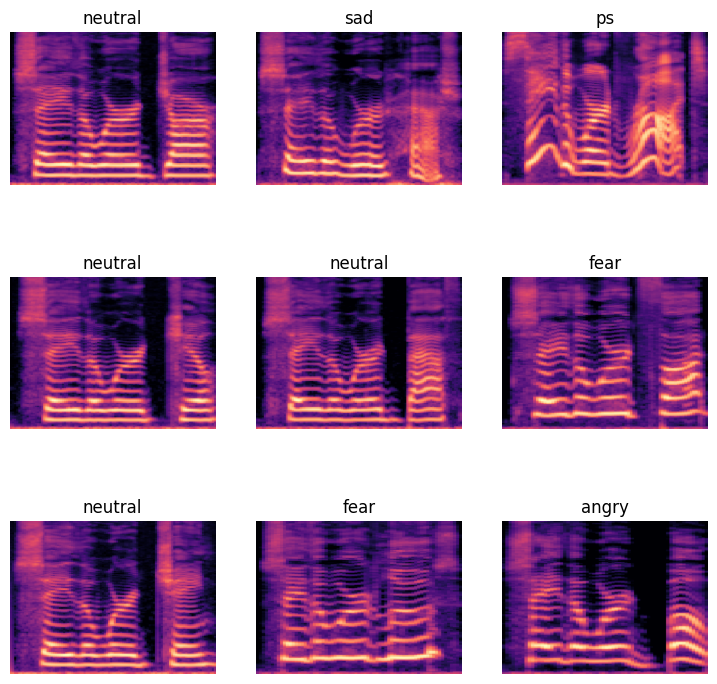

In [ ]:
dls.train.show_batch()

### Fine-Tuning

Fine-Tune the model. We already see a very good accuracy (above 99%) on the validation dataset, which is good enough in this case.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.195950,0.113646,0.038095,07:37


epoch,train_loss,valid_loss,error_rate,time
0,0.086052,0.055450,0.011905,00:31
1,0.041243,0.032853,0.002381,00:30
2,0.020348,0.038915,0.007143,00:30
3,0.010536,0.034887,0.007143,00:30


### Evaluation

Examining the model classification

* The model often confuses pleasantly surprise with happy and disgust while it confuses fear with sadness.

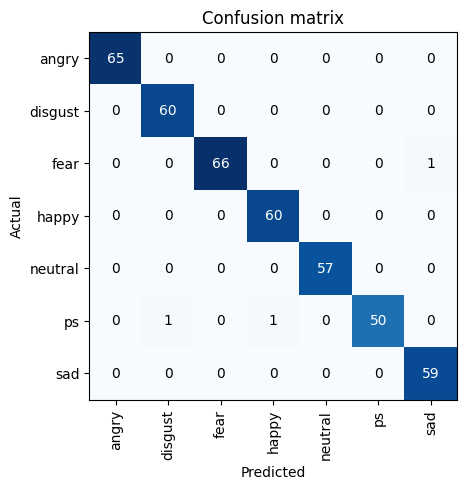

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

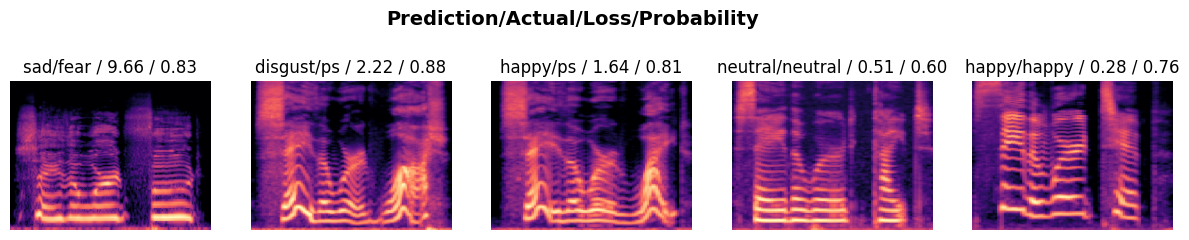

In [ ]:
interp.plot_top_losses(5, nrows=1)

Exporting the model for putting it into application

In [ ]:
save_file_path = cwd / "emotion_model.pkl"
learn.export(save_file_path)